In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from os.path import join

import matplotlib.pyplot as plt

from keras.utils import to_categorical
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Model, model_from_json
from keras import optimizers
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns

from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
# Here we allow access to drives directory (to load the model)

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 21s 0us/step


In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
# normalise and center the mean

x_train = x_train.astype("float32")  
x_test = x_test.astype("float32")
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [0]:
def save_model(model,filename):
    # this is a helper function used to save a keras NN model architecture and weights
    json_string = model.to_json()
    path = join('/content/drive/My Drive/deep learning/models', filename)
    open(path + '_architecture.json', 'w').write(json_string)
    model.save_weights(path + '_model_weights.h5', overwrite=True)
    
def read_model(filename):
    # this is a helper function used to restore a keras NN model architecture and weights
    path = join('/content/drive/My Drive/deep learning/models', filename)
    model = model_from_json(open(path + '_architecture.json', 'r').read())
    model.load_weights(path + '_model_weights.h5')
    return model

In [0]:
model = read_model('fine_tuning_normal_1911')

In [0]:
# get only the top 20 layers so we remove the output layer 

last = model.layers[20].output

In [0]:
# create the model without the output layer

feature_model = Model(model.input, last)

In [10]:
feature_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-3, momentum=0.9), metrics=['accuracy'])
feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [0]:
# we use the output of the last layer as fetures so they will be the input to the KNN model

featurs = feature_model.predict(x_train)

In [0]:
# we preform the prediction also on the test set to evaluate the accurecy on test set

features_test = feature_model.predict(x_test)

In [13]:
# create simple KNN classifier and train this model on the feature we extract from the original model

classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(featurs, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


[[904   5  21  11   8   1   1   5  31  13]
 [ 27 913   0   3   0   0   4   2  12  39]
 [ 72   0 790  32  46  18  28  11   3   0]
 [ 63   2  42 676  27 119  38  19   6   8]
 [ 37   1  34  30 825  25  18  26   4   0]
 [ 42   1  14 129  27 745  13  27   1   1]
 [ 26   0  28  32  13   7 880   5   5   4]
 [ 39   3  16  23  28  19   2 866   1   3]
 [ 30  13   3   8   3   0   2   1 928  12]
 [ 25  46   3   4   1   3   3   3  15 897]]

model accuracy on test set is: 84.24000000000001%


Text(0.5,1,'CIFAR-10 Convolutional model \n classification results on test set')

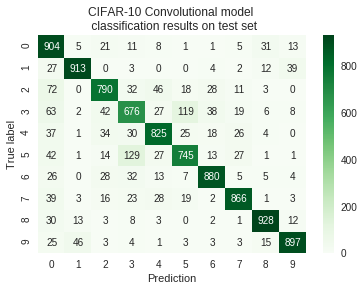

In [14]:
 # accuracy on test set

y_test_cat = np.argmax(y_test, axis=1)
preds = classifier.predict(features_test)
pred_cat = np.argmax(preds, axis=1)
print('')
print(confusion_matrix(y_test_cat, pred_cat))
print()
print('model accuracy on test set is: {}%'.format(accuracy_score(y_test_cat, pred_cat)*100))
sns.heatmap(confusion_matrix(y_test_cat, pred_cat), cmap='Greens', annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('CIFAR-10 Convolutional model \n classification results on test set')


[[4878    6   29    8    5    2    1    8   51   12]
 [  25 4880    0    5    0    0    1    1   16   72]
 [ 143    1 4716   33   39   26   29   10    2    1]
 [ 183    3   39 4416   39  247   42   19    6    6]
 [ 124    0   54   52 4672   25   24   41    8    0]
 [ 133    0   25  294   48 4416   11   70    2    1]
 [  82    2   38   46   14   22 4790    2    3    1]
 [  91    1   11   37   45   35    1 4774    1    4]
 [  74   13    2    5    4    4    1    0 4878   19]
 [  47   57    3    6    3    1    1    1   19 4862]]

model accuracy on train set is: 94.56400000000001%


Text(0.5,1,'CIFAR-10 Convolutional model \n classification results on train set')

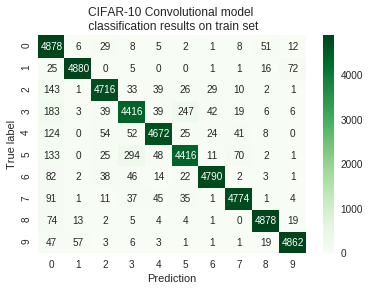

In [15]:
 # accuracy on train set

y_train_cat = np.argmax(y_train, axis=1)
preds = classifier.predict(featurs)
pred_cat = np.argmax(preds, axis=1)
print('')
print(confusion_matrix(y_train_cat, pred_cat))
print()
print('model accuracy on train set is: {}%'.format(accuracy_score(y_train_cat, pred_cat)*100))
sns.heatmap(confusion_matrix(y_train_cat, pred_cat), cmap='Greens', annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('CIFAR-10 Convolutional model \n classification results on train set')